In [1]:
import sys

sys.path.append("../")

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import chirp, windows
from scipy.signal import correlate, correlation_lags
from positioning.readwav import readwav
from positioning.get_spectrum_amplitude import get_tukey_spectrum_amplitude
from positioning.sound_db import TukeyDB
from positioning import tools
from positioning.make_wave import chirp_exp
from positioning.create_db import create_3d_spectrum_db
from positioning.estimate import estimate_direction_3d

In [3]:
sns.set(style="whitegrid")

In [5]:
db = create_3d_spectrum_db("../data/reference_3d_phone")

In [6]:
db.shape

(81, 31, 28)

In [9]:
test_signal_d = [readwav(f"../data/pos_3d_first/test{i}d.wav")[:, 1] for i in range(9)]

In [10]:
est_direction = []
for s in test_signal_d:
    est_d = []
    for i in range(100):
        d = estimate_direction_3d(db, s[i * 96000 : (i + 2) * 96000])
        est_d.append(d)
    est_direction.append(est_d)
est_direction = np.array(est_direction)
est_direction.shape

(9, 100, 2)

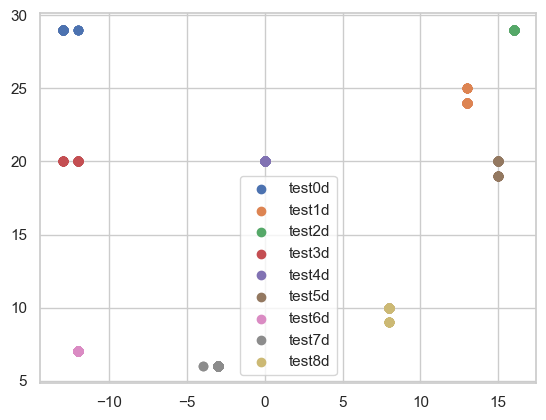

In [12]:
for i in range(9):
    plt.scatter(est_direction[i, :, 0], est_direction[i, :, 1], label=f"test{i}d")
plt.legend()

In [13]:
df_true = pd.read_csv("../data/pos_3d_first/true_positions.csv")

In [14]:
df_true.head()

,x,y,z,mcs_x,mcs_y,mcs_z,distance,azimuth,elevation
0,-0.341,0.937,-0.465,0.659,1.437,1.035,1.1,-20.0,25.0
1,0.000,0.997,-0.465,1.000,1.497,1.035,1.1,0.0,25.0
2,0.341,0.937,-0.465,1.341,1.437,1.035,1.1,20.0,25.0
3,-0.340,1.271,-0.479,0.660,1.771,1.021,1.4,-15.0,20.0
4,0.000,1.316,-0.479,1.000,1.816,1.021,1.4,0.0,20.0


In [20]:
df_est = pd.DataFrame()
for i in range(9):
    df_est = pd.concat(
        [
            df_est,
            pd.DataFrame(est_direction[i, :, :], columns=["azimuth", "elevation"])
            .assign(test=i)
            .assign(azimuth_error=lambda x: np.abs(x.azimuth - df_true.azimuth[i]))
            .assign(
                elevation_error=lambda x: np.abs(x.elevation - df_true.elevation[i])
            ),
        ]
    )
df_est.head()

,azimuth,elevation,test,azimuth_error,elevation_error
0,-12,29,0,8.0,4.0
1,-12,29,0,8.0,4.0
2,-12,29,0,8.0,4.0
3,-12,29,0,8.0,4.0
4,-12,29,0,8.0,4.0


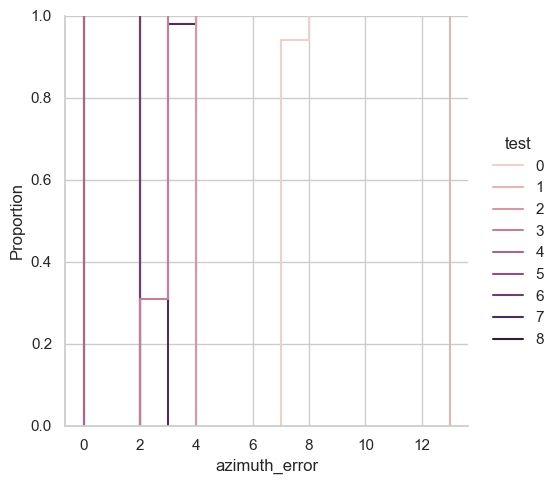

In [22]:
sns.displot(df_est, x="azimuth_error", hue="test", kind="ecdf")

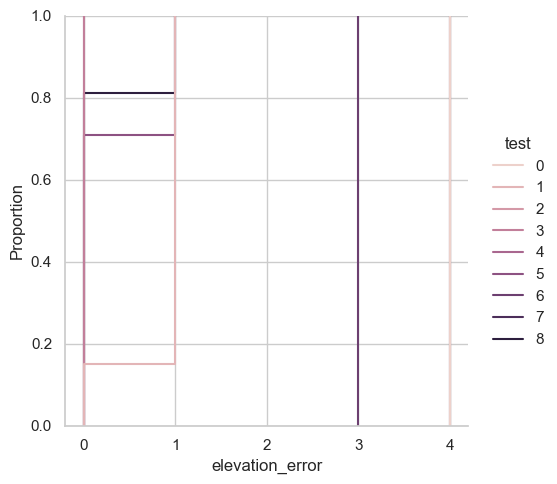

In [23]:
sns.displot(df_est, x="elevation_error", hue="test", kind="ecdf")

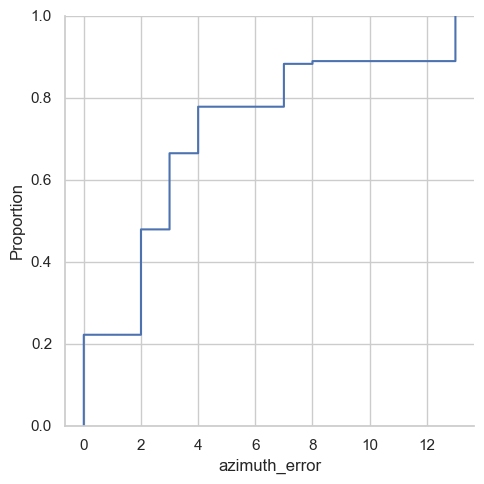

In [24]:
sns.displot(df_est, x="azimuth_error", kind="ecdf")

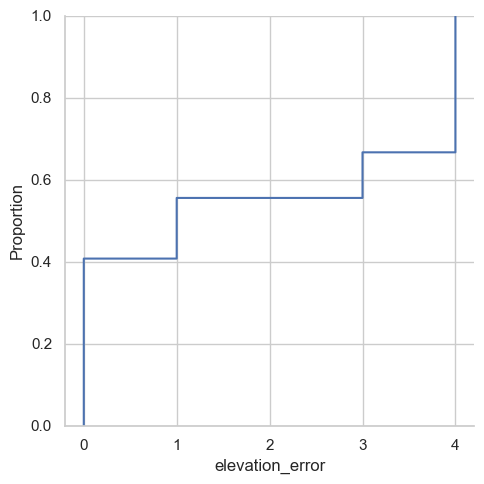

In [25]:
sns.displot(df_est, x="elevation_error", kind="ecdf")

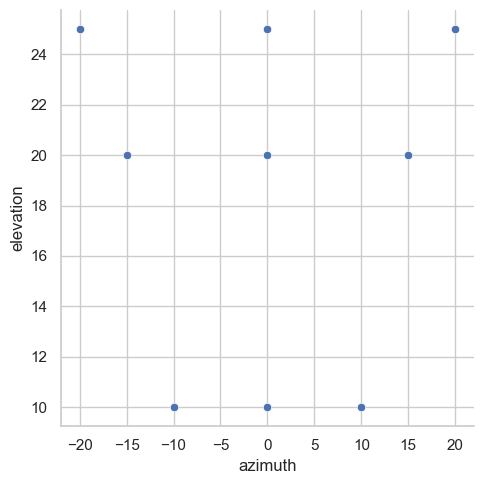

In [26]:
sns.relplot(df_true, x="azimuth", y="elevation")

In [27]:
def get_height(sound0):
    ref_chirp = chirp_exp(15000, 22000, 0.05, 0.5, 48000) * windows.tukey(
        int(48000 * 0.05)
    )
    corr2 = correlate(sound0, ref_chirp)
    lags2 = correlation_lags(len(sound0), len(ref_chirp))
    corr2 = corr2 / np.max(corr2)
    first_max_i = np.argmax(corr2[:10000])
    max_i_array = np.array([first_max_i])
    corr2_oneset = np.array([corr2[first_max_i - 100 : first_max_i + 3500]])
    for i in range(1, 5):
        max_i_k = (
            np.argmax(
                corr2[first_max_i + (7200 * i) - 3600 : first_max_i + (7200 * i) + 3600]
            )
            + first_max_i
            + (7200 * i)
            - 3600
        )
        max_i_array = np.append(max_i_array, max_i_k)
        corr2_oneset = np.concatenate(
            [corr2_oneset, [corr2[max_i_k - 100 : max_i_k + 3500]]]
        )
    corr2_avg = np.mean(corr2_oneset, axis=0)
    corr2_avg_max_i = np.argmax(corr2_avg)
    corr2_avg_second_i = (
        np.argmax(corr2_avg[corr2_avg_max_i + 100 :]) + corr2_avg_max_i + 100
    )
    estimated_height = (corr2_avg_second_i - corr2_avg_max_i) / 48000 * 340 / 2
    return estimated_height

In [28]:
test_signal_h = [readwav(f"../data/pos_3d_first/test{i}h.wav")[:, 1] for i in range(9)]

In [29]:
est_height = []
for s in test_signal_h:
    hh = []
    for i in range(90):
        h = get_height(s[i * 7200 : i * 7200 + 48000])
        hh.append(h)
    est_height.append(hh)
est_height = np.array(est_height)
est_height.shape

(9, 90)

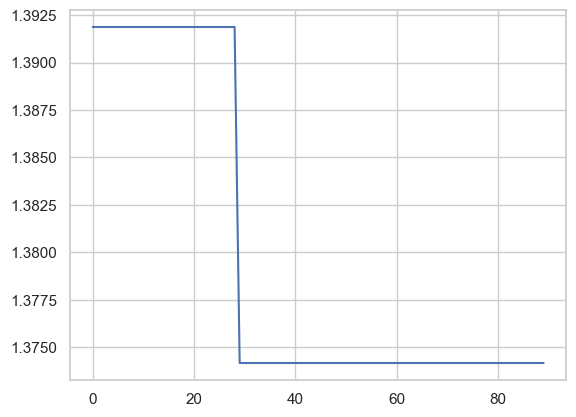

In [32]:
plt.plot(est_height[0, :])

In [33]:
est_height_avg = np.mean(est_height, axis=1)
print(est_height_avg)

[1.37987269 1.3949838  1.67638889 1.41993287 1.41627315 1.41115741
 1.22911574 1.2262037  1.23155556]


In [35]:
est_height_avg_extend = np.tile(est_height_avg, (10, 1)).T
est_height_avg_extend.shape

(9, 10)

In [36]:
est_height_hundred = np.concatenate([est_height, est_height_avg_extend], axis=1)
est_height_hundred.shape

(9, 100)

In [37]:
est_height_floor = 2.5 - est_height_hundred

In [38]:
df_est["height"] = est_height_floor.flatten()
df_est.head()

,azimuth,elevation,test,azimuth_error,elevation_error,height
0,-12,29,0,8.0,4.0,1.108125
1,-12,29,0,8.0,4.0,1.108125
2,-12,29,0,8.0,4.0,1.108125
3,-12,29,0,8.0,4.0,1.108125
4,-12,29,0,8.0,4.0,1.108125


In [42]:
height_error = np.abs(
    np.array([est_height_floor[i, :] - df_true.iloc[i]["mcs_z"] for i in range(9)])
)

In [43]:
height_error.shape

(9, 100)

In [44]:
df_est["height_error"] = height_error.flatten()
df_est.head()

,azimuth,elevation,test,azimuth_error,elevation_error,height,height_error
0,-12,29,0,8.0,4.0,1.108125,0.073125
1,-12,29,0,8.0,4.0,1.108125,0.073125
2,-12,29,0,8.0,4.0,1.108125,0.073125
3,-12,29,0,8.0,4.0,1.108125,0.073125
4,-12,29,0,8.0,4.0,1.108125,0.073125


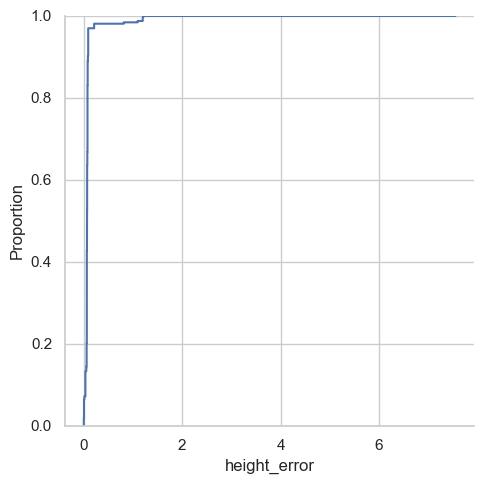

In [45]:
sns.displot(df_est, x="height_error", kind="ecdf")

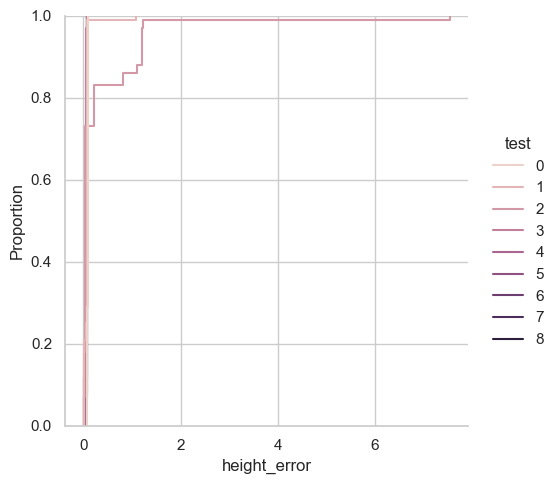

In [46]:
sns.displot(df_est, x="height_error", kind="ecdf", hue="test")

(0.0, 1.0)

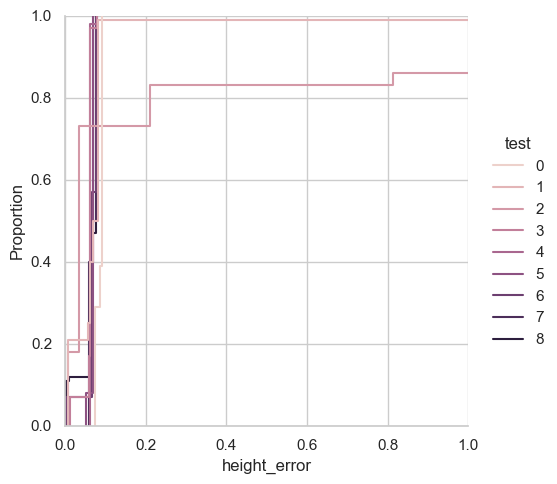

In [47]:
sns.displot(df_est, x="height_error", kind="ecdf", hue="test")
plt.xlim(0, 1)

In [48]:
def calc_position(azimuth, elevation, height):
    x = (1.5 - height) * np.sin(np.radians(azimuth)) / np.sin(np.radians(elevation))
    y = (1.5 - height) * np.cos(np.radians(azimuth)) / np.sin(np.radians(elevation))
    z = height
    return x, y, z

In [49]:
df_est["x"], df_est["y"], df_est["z"] = calc_position(
    df_est["azimuth"], df_est["elevation"], df_est["height"]
)
df_est.head()

,azimuth,elevation,test,azimuth_error,elevation_error,height,height_error,x,y,z
0,-12,29,0,8.0,4.0,1.108125,0.073125,-0.168056,0.790644,1.108125
1,-12,29,0,8.0,4.0,1.108125,0.073125,-0.168056,0.790644,1.108125
2,-12,29,0,8.0,4.0,1.108125,0.073125,-0.168056,0.790644,1.108125
3,-12,29,0,8.0,4.0,1.108125,0.073125,-0.168056,0.790644,1.108125
4,-12,29,0,8.0,4.0,1.108125,0.073125,-0.168056,0.790644,1.108125


In [50]:
pos_error = np.sqrt(
    np.array(
        [
            (df_est.query("test == @i")["x"] - df_true.iloc[i]["x"]) ** 2
            + (df_est.query("test == @i")["y"] - df_true.iloc[i]["y"]) ** 2
            + (df_est.query("test == @i")["z"] - df_true.iloc[i]["mcs_z"]) ** 2
            for i in range(9)
        ]
    )
)
pos_error.shape

(9, 100)

In [51]:
df_est["pos_error"] = pos_error.flatten()
df_est.head()

,azimuth,elevation,test,azimuth_error,elevation_error,height,height_error,x,y,z,pos_error
0,-12,29,0,8.0,4.0,1.108125,0.073125,-0.168056,0.790644,1.108125,0.238069
1,-12,29,0,8.0,4.0,1.108125,0.073125,-0.168056,0.790644,1.108125,0.238069
2,-12,29,0,8.0,4.0,1.108125,0.073125,-0.168056,0.790644,1.108125,0.238069
3,-12,29,0,8.0,4.0,1.108125,0.073125,-0.168056,0.790644,1.108125,0.238069
4,-12,29,0,8.0,4.0,1.108125,0.073125,-0.168056,0.790644,1.108125,0.238069


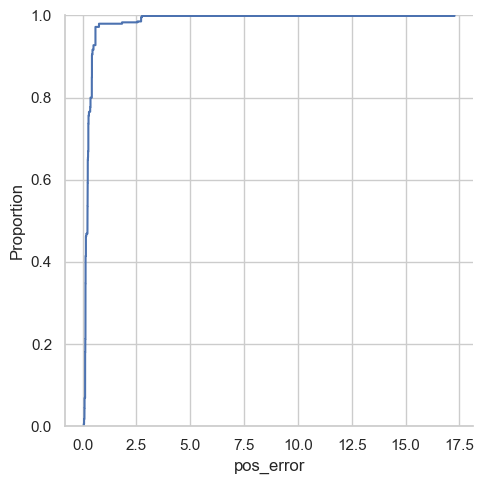

In [52]:
sns.displot(df_est, x="pos_error", kind="ecdf")

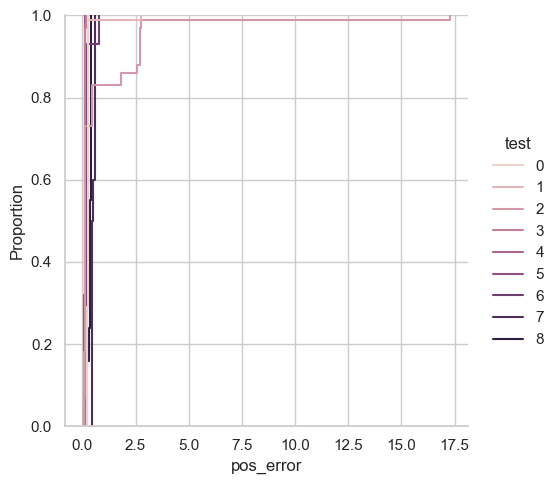

In [53]:
sns.displot(df_est, x="pos_error", kind="ecdf", hue="test")

In [55]:
pos_err_90p = np.percentile(df_est["pos_error"], 90)
pos_err_50p = np.percentile(df_est["pos_error"], 50)
azimuth_err_90p = np.percentile(df_est["azimuth_error"], 90)
azimuth_err_50p = np.percentile(df_est["azimuth_error"], 50)
elevation_err_90p = np.percentile(df_est["elevation_error"], 90)
elevation_err_50p = np.percentile(df_est["elevation_error"], 50)
height_err_90p = np.percentile(df_est["height_error"], 90)
height_err_50p = np.percentile(df_est["height_error"], 50)
print(
    f"pos_err_90p: {pos_err_90p:.3f}, pos_err_50p: {pos_err_50p:.3f}, azimuth_err_90p: {azimuth_err_90p}, azimuth_err_50p: {azimuth_err_50p}, elevation_err_90p: {elevation_err_90p}, elevation_err_50p: {elevation_err_50p}, height_err_90p: {height_err_90p:.3f}, height_err_50p: {height_err_50p:.3f}"
)

pos_err_90p: 0.433, pos_err_50p: 0.223, azimuth_err_90p: 13.0, azimuth_err_50p: 3.0, elevation_err_90p: 4.0, elevation_err_50p: 1.0, height_err_90p: 0.085, height_err_50p: 0.066
